In [208]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm



# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [209]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [210]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [5]:
# '아이스크림'만 빼서 df생성
item = '아이스크림'
grouped_by = 'week'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

# 주단위로 종합해보기

In [65]:
gs_week_w = gs_day_w.copy()
gs_week_w = addDayWeek(gs_week_w)

cols_Ineed = ['week','category', 'qty', 'temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',
              'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 
              'health_blog','health_twitter', 'health_news', 'health_total',
              'date_blog','date_twitter', 'date_news', 'date_total',
              'br_blog', 'br_twitter','br_news', 'br_total',
              'hobby_blog', 'hobby_twitter', 'hobby_news','hobby_total']
gs_week_w = gs_week_w[cols_Ineed]

In [66]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'snow', 'rain', 'PM10']
lowVIF(w,40,list_col)

,VIF_Factor,features
0,1.047669,snow
1,1.305399,rain
2,3.867186,temp
3,4.765719,PM10
4,6.540650,cloud
5,8.176526,lgt_time
6,8.996828,wind


In [67]:
gs_week_w = gs_week_w[['week','qty']+list_col].groupby('week').mean().reset_index()
# gs_week_w.tail(2)

# week: 1~105 = 2016~2017년
# week: 106~157 = 2018년
train_data = gs_week_w.loc[gs_week_w.week <=105]
test_date = gs_week_w.loc[gs_week_w.week >105]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_week_w.loc[:,'temp':'PM10']
target = gs_week_w.loc[:,'qty']

In [68]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [69]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 7
Number of nun-numerical columns with no nan values : 0


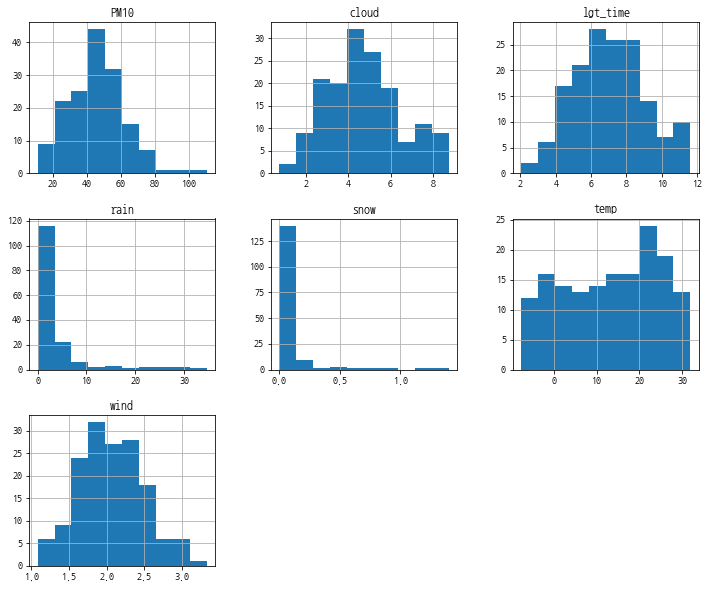

In [70]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

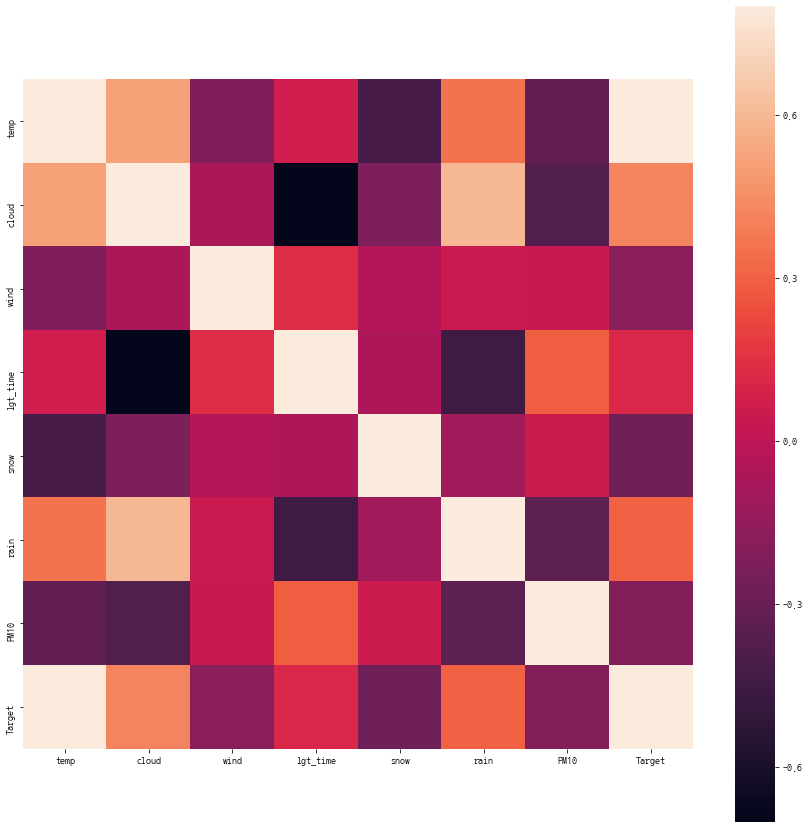

In [24]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [71]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 7 columns before encoding categorical features
There are 7 columns after encoding categorical features


In [72]:
# 여기서 이코드으 제작자는 수동으로 훈련/검증셋을 나눔
# 105주 기준으로 나누겠음
cut_line = 106
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()
train.shape

(106, 7)

In [73]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [74]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'GS(0718)-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [75]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=106을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 84 samples, validate on 22 samples
Epoch 1/500
84/84 [==============================] - 0s 3ms/step - loss: 21743.7494 - mean_absolute_error: 21743.7494 - val_loss: 13935.6494 - val_mean_absolute_error: 13935.6494

Epoch 00001: val_loss improved from inf to 13935.64941, saving model to GS(0718)-아이스크림week-Weights-001--13935.64941.hdf5
Epoch 2/500
84/84 [==============================] - 0s 131us/step - loss: 21740.8950 - mean_absolute_error: 21740.8950 - val_loss: 13932.2031 - val_mean_absolute_error: 13932.2031

Epoch 00002: val_loss improved from 13935.64941 to 13932.20312, saving model to GS(0718)-아이스크림week-Weights-002--13932.20312.hdf5
Epoch 3/500
84/84 [==============================] - 0s 107us/step - loss: 21735.2713 - mean_absolute_error: 21735.2713 - val_loss: 13924.6621 - val_mean_absolute_error: 13924.6621

Epoch 00003: val_loss improved from 13932.20312 to 13924.66211, saving model to GS(0718)-아이스크림week-Weights-003--13924.66211.hdf5
Epoch 4/500
84/84 [==============

84/84 [==============================] - 0s 131us/step - loss: 3228.4541 - mean_absolute_error: 3228.4541 - val_loss: 4894.3721 - val_mean_absolute_error: 4894.3721

Epoch 00063: val_loss did not improve from 3026.90063
Epoch 64/500
84/84 [==============================] - 0s 107us/step - loss: 3247.1108 - mean_absolute_error: 3247.1108 - val_loss: 5044.9268 - val_mean_absolute_error: 5044.9268

Epoch 00064: val_loss did not improve from 3026.90063
Epoch 65/500
84/84 [==============================] - 0s 107us/step - loss: 3201.9045 - mean_absolute_error: 3201.9045 - val_loss: 5412.6187 - val_mean_absolute_error: 5412.6187

Epoch 00065: val_loss did not improve from 3026.90063
Epoch 66/500
84/84 [==============================] - 0s 131us/step - loss: 3247.9723 - mean_absolute_error: 3247.9723 - val_loss: 5293.1909 - val_mean_absolute_error: 5293.1909

Epoch 00066: val_loss did not improve from 3026.90063
Epoch 67/500
84/84 [==============================] - 0s 119us/step - loss: 3261.

84/84 [==============================] - 0s 214us/step - loss: 3005.2237 - mean_absolute_error: 3005.2237 - val_loss: 5164.7144 - val_mean_absolute_error: 5164.7144

Epoch 00133: val_loss did not improve from 3026.90063
Epoch 134/500
84/84 [==============================] - 0s 166us/step - loss: 3008.1469 - mean_absolute_error: 3008.1469 - val_loss: 5324.8457 - val_mean_absolute_error: 5324.8457

Epoch 00134: val_loss did not improve from 3026.90063
Epoch 135/500
84/84 [==============================] - 0s 119us/step - loss: 3035.7538 - mean_absolute_error: 3035.7538 - val_loss: 5206.1250 - val_mean_absolute_error: 5206.1250

Epoch 00135: val_loss did not improve from 3026.90063
Epoch 136/500
84/84 [==============================] - 0s 119us/step - loss: 2989.3084 - mean_absolute_error: 2989.3084 - val_loss: 4561.4248 - val_mean_absolute_error: 4561.4248

Epoch 00136: val_loss did not improve from 3026.90063
Epoch 137/500
84/84 [==============================] - 0s 107us/step - loss: 3

84/84 [==============================] - 0s 107us/step - loss: 2891.6648 - mean_absolute_error: 2891.6648 - val_loss: 4882.6387 - val_mean_absolute_error: 4882.6387

Epoch 00203: val_loss did not improve from 3026.90063
Epoch 204/500
84/84 [==============================] - 0s 107us/step - loss: 2916.5289 - mean_absolute_error: 2916.5289 - val_loss: 5049.2778 - val_mean_absolute_error: 5049.2778

Epoch 00204: val_loss did not improve from 3026.90063
Epoch 205/500
84/84 [==============================] - 0s 142us/step - loss: 2888.7150 - mean_absolute_error: 2888.7150 - val_loss: 4738.1758 - val_mean_absolute_error: 4738.1758

Epoch 00205: val_loss did not improve from 3026.90063
Epoch 206/500
84/84 [==============================] - 0s 142us/step - loss: 2899.2393 - mean_absolute_error: 2899.2393 - val_loss: 4909.6172 - val_mean_absolute_error: 4909.6172

Epoch 00206: val_loss did not improve from 3026.90063
Epoch 207/500
84/84 [==============================] - 0s 95us/step - loss: 29

84/84 [==============================] - 0s 107us/step - loss: 2798.0380 - mean_absolute_error: 2798.0380 - val_loss: 4517.1787 - val_mean_absolute_error: 4517.1787

Epoch 00273: val_loss did not improve from 3026.90063
Epoch 274/500
84/84 [==============================] - 0s 107us/step - loss: 2830.1478 - mean_absolute_error: 2830.1478 - val_loss: 4587.9009 - val_mean_absolute_error: 4587.9009

Epoch 00274: val_loss did not improve from 3026.90063
Epoch 275/500
84/84 [==============================] - 0s 107us/step - loss: 2831.8083 - mean_absolute_error: 2831.8083 - val_loss: 5212.2534 - val_mean_absolute_error: 5212.2534

Epoch 00275: val_loss did not improve from 3026.90063
Epoch 276/500
84/84 [==============================] - 0s 131us/step - loss: 2858.2917 - mean_absolute_error: 2858.2917 - val_loss: 4999.5518 - val_mean_absolute_error: 4999.5518

Epoch 00276: val_loss did not improve from 3026.90063
Epoch 277/500
84/84 [==============================] - 0s 119us/step - loss: 2

84/84 [==============================] - 0s 142us/step - loss: 2717.6492 - mean_absolute_error: 2717.6492 - val_loss: 4756.2886 - val_mean_absolute_error: 4756.2886

Epoch 00343: val_loss did not improve from 3026.90063
Epoch 344/500
84/84 [==============================] - 0s 130us/step - loss: 2705.8666 - mean_absolute_error: 2705.8666 - val_loss: 4524.0879 - val_mean_absolute_error: 4524.0879

Epoch 00344: val_loss did not improve from 3026.90063
Epoch 345/500
84/84 [==============================] - 0s 107us/step - loss: 2722.7929 - mean_absolute_error: 2722.7929 - val_loss: 5019.4902 - val_mean_absolute_error: 5019.4902

Epoch 00345: val_loss did not improve from 3026.90063
Epoch 346/500
84/84 [==============================] - 0s 119us/step - loss: 2790.6017 - mean_absolute_error: 2790.6017 - val_loss: 4856.5879 - val_mean_absolute_error: 4856.5879

Epoch 00346: val_loss did not improve from 3026.90063
Epoch 347/500
84/84 [==============================] - 0s 107us/step - loss: 2

84/84 [==============================] - 0s 142us/step - loss: 2648.5685 - mean_absolute_error: 2648.5685 - val_loss: 4459.9893 - val_mean_absolute_error: 4459.9893

Epoch 00413: val_loss did not improve from 3026.90063
Epoch 414/500
84/84 [==============================] - 0s 154us/step - loss: 2583.2840 - mean_absolute_error: 2583.2840 - val_loss: 4843.9165 - val_mean_absolute_error: 4843.9165

Epoch 00414: val_loss did not improve from 3026.90063
Epoch 415/500
84/84 [==============================] - 0s 107us/step - loss: 2570.3139 - mean_absolute_error: 2570.3139 - val_loss: 4964.7661 - val_mean_absolute_error: 4964.7661

Epoch 00415: val_loss did not improve from 3026.90063
Epoch 416/500
84/84 [==============================] - 0s 142us/step - loss: 2612.5956 - mean_absolute_error: 2612.5956 - val_loss: 4602.5723 - val_mean_absolute_error: 4602.5723

Epoch 00416: val_loss did not improve from 3026.90063
Epoch 417/500
84/84 [==============================] - 0s 131us/step - loss: 2

84/84 [==============================] - 0s 119us/step - loss: 2635.4328 - mean_absolute_error: 2635.4328 - val_loss: 3852.2307 - val_mean_absolute_error: 3852.2307

Epoch 00483: val_loss did not improve from 3026.90063
Epoch 484/500
84/84 [==============================] - 0s 131us/step - loss: 2557.2955 - mean_absolute_error: 2557.2955 - val_loss: 5182.3496 - val_mean_absolute_error: 5182.3496

Epoch 00484: val_loss did not improve from 3026.90063
Epoch 485/500
84/84 [==============================] - 0s 131us/step - loss: 2767.2019 - mean_absolute_error: 2767.2019 - val_loss: 5596.8931 - val_mean_absolute_error: 5596.8931

Epoch 00485: val_loss did not improve from 3026.90063
Epoch 486/500
84/84 [==============================] - 0s 119us/step - loss: 2632.1825 - mean_absolute_error: 2632.1825 - val_loss: 4035.4048 - val_mean_absolute_error: 4035.4048

Epoch 00486: val_loss did not improve from 3026.90063
Epoch 487/500
84/84 [==============================] - 0s 107us/step - loss: 2

In [76]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = 'GS(0718)-아이스크림week-Weights-033--3026.90063.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [127]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = gs_week_w.loc[:,'temp':'PM10']
# target3 = gs_week_w.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~106 / 106~156
trainXy = gs_week_w.loc[:cut_line]
testXy = gs_week_w.loc[cut_line:]
train_X = trainXy.loc[:,'temp':'PM10']
train_y = trainXy.loc[:,'qty']
val_X = testXy.loc[:,'temp':'PM10']
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.975
검증세트점수 : 0.879
XGBoost을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.997
검증세트점수 : 0.872
LinearRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.797
검증세트점수 : 0.741
RidgeRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.783
검증세트점수 : 0.707
LassoRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.797
검증세트점수 : 0.741
OLS을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.797


In [128]:
# list_col # ['temp', 'cloud', 'wind', 'lgt_time', 'snow', 'rain', 'PM10']

# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     55.45
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.81e-31
Time:                        16:53:08   Log-Likelihood:                -1069.6
No. Observations:                 107   AIC:                             2155.
Df Residuals:                      99   BIC:                             2177.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2743.6497   6581.311      0.417      0.678   -1.03e+04    1.58e+04
temp        1067.5690     94.484     11.299      0.000     880.092    1255.046
cloud       -367.2699    765.867     -0.480      0.633   -1886.917    1152.377
wind         622.8571   1605.397      0.388      0.699   -2562.598    3808.312
lgt_time     -32.2936    600.064     -0.054      0.957   -1222.951    1158.364
snow        7373.0822   3244.544      2.272      0.025     935.203    1.38e+04
rain          43.4600    115.100      0.378      0.707    -184.924     271.844
PM10          72.0423     37.915      1.900      0.060      -3.189     147.274
==============================================================================
Omnibus:                        2.273   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.235
Skew:                           0.344   Prob(JB):                        0.327
Kurtosis:                       2.829   Cond. No.                         664.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
combined = gs_week_w.loc[:,'temp':'PM10']
target = gs_week_w.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['week'] = gs_week_w['week']
result_df['qty'] = gs_week_w.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

## 실험 구간

In [162]:

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~106 / 106~156
trainXy = gs_week_w.loc[:cut_line]
testXy = gs_week_w.loc[cut_line:]
train_X =pd.DataFrame(trainXy.loc[:,'temp'])
train_y = trainXy.loc[:,'qty']
val_X = pd.DataFrame(testXy.loc[:,'temp'])
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=['temp'])
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
target = gs_week_w.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['week'] = gs_week_w['week']
result_df['qty'] = gs_week_w.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
# result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.958
검증세트점수 : 0.693
XGBoost을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.956
검증세트점수 : 0.728
LinearRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.777
검증세트점수 : 0.710
RidgeRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.771
검증세트점수 : 0.716
LassoRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.777
검증세트점수 : 0.710
OLS을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.777


# ============================================

In [182]:
df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [115]:
qty_columns = list(df_graph.columns)[1:9]
weather_columns = list(df_graph.columns)[9:]
print(qty_columns)
print(weather_columns)

['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty', 'lasso_qty', 'ols_qty']
['temp', 'cloud', 'wind', 'lgt_time', 'snow', 'rain', 'PM10']


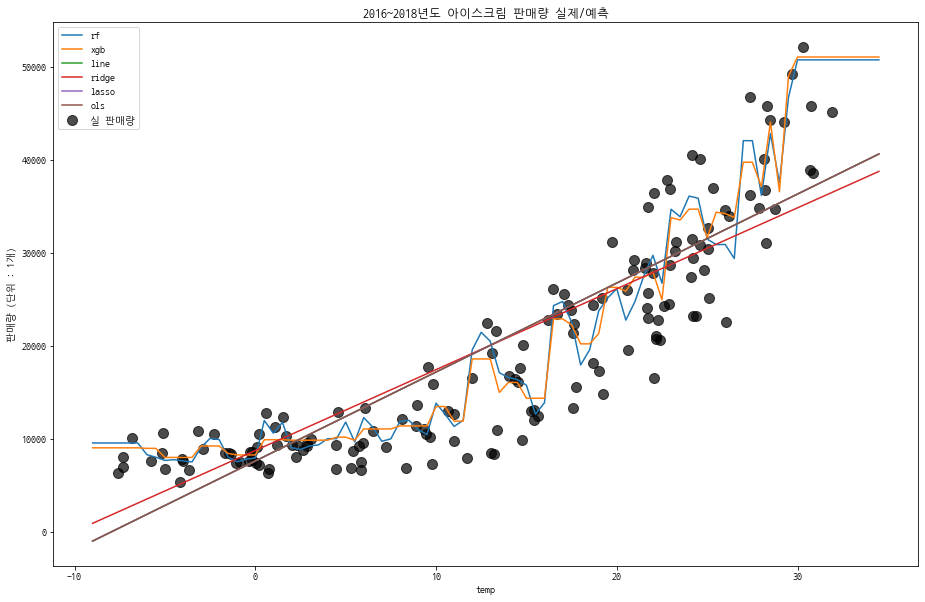

In [207]:
x_temp = pd.DataFrame()
# x_temp['temp'] = list(range(-10,35,1))
x_temp['temp'] = np.arange(-9,35,0.5)
combined = x_temp
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

# 2016~2018, 일조시간
df_graph = df.copy()
plt.figure(figsize=(15.5, 10))
plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
plt.plot(x_temp, RFpredicted, label = 'rf')
plt.plot(x_temp, XGBpredictions, label = 'xgb')
plt.plot(x_temp, linPred, label = 'line')
plt.plot(x_temp, ridPred, label = 'ridge')
plt.plot(x_temp, lassoPred, label = 'lasso')
plt.plot(x_temp, olsPred, label = 'ols')
plt.plot()
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.xlabel(weather_columns[0])
plt.ylabel('판매량 (단위 : 1개)')
plt.show()

# 실험

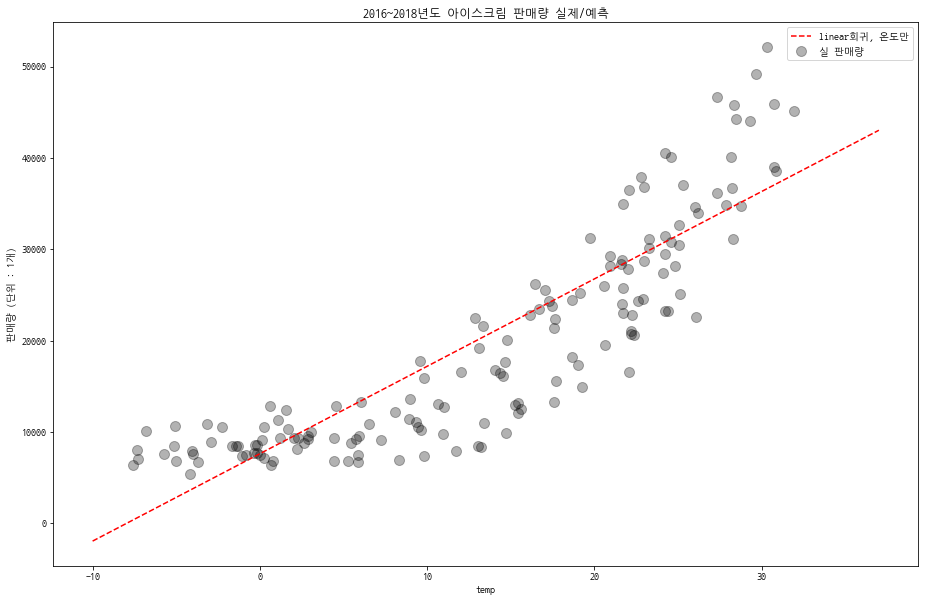

In [171]:
intercept_lin = linReg.intercept_
coef_line = linReg.coef_
# list_col
linePredict = list()
x_temp = list(range(-10,38,1))
for temperature in x_temp:
    linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# 2016~2018, 일조시간
df_graph = df.copy()
plt.figure(figsize=(15.5, 10))
plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# for q_name in qty_columns:
#     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
#     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
#     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
#     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
#     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
#     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
#     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
#     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
#     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.xlabel(weather_columns[0])
plt.ylabel('판매량 (단위 : 1개)')
plt.show()

# 시간의 경과에 따른 예측량 비교

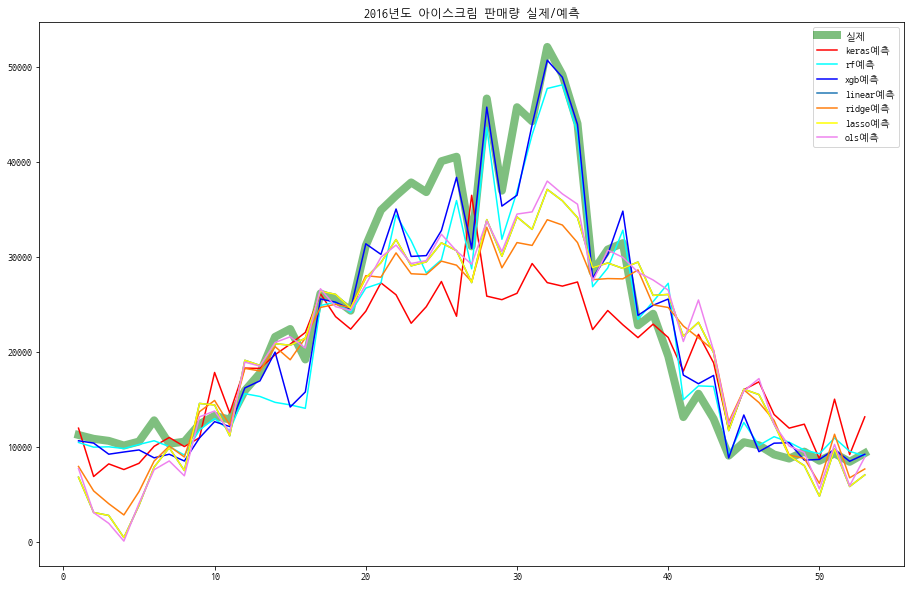

In [94]:
# 2016
df_graph = result_df.loc[result_df.week <=53]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

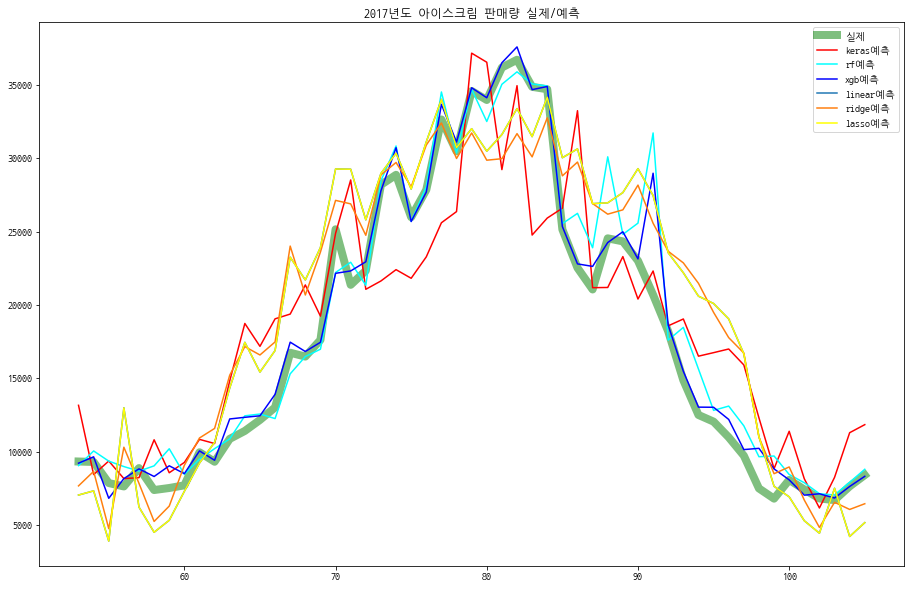

In [84]:
# 2017
df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

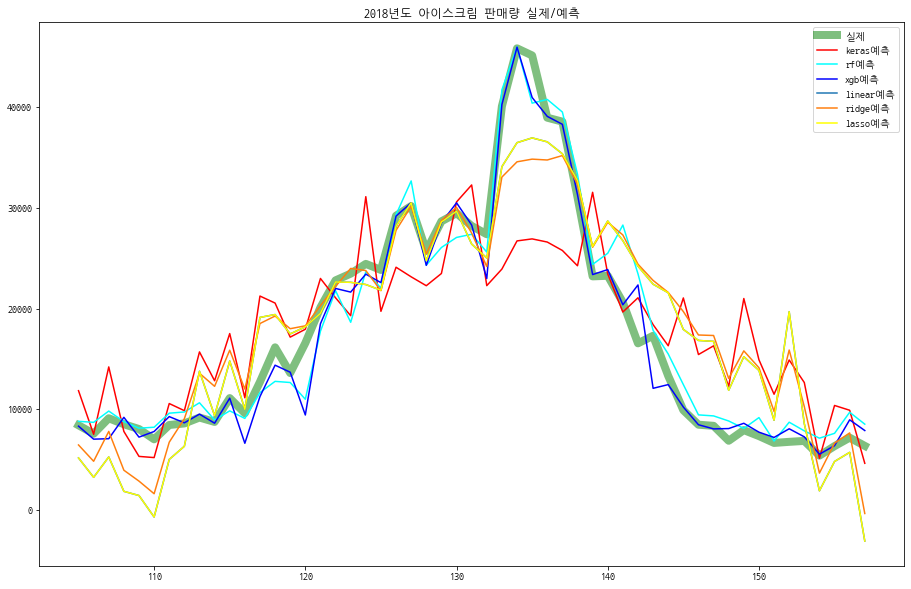

In [85]:
# 2018
df_graph = result_df.loc[(result_df.week >=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

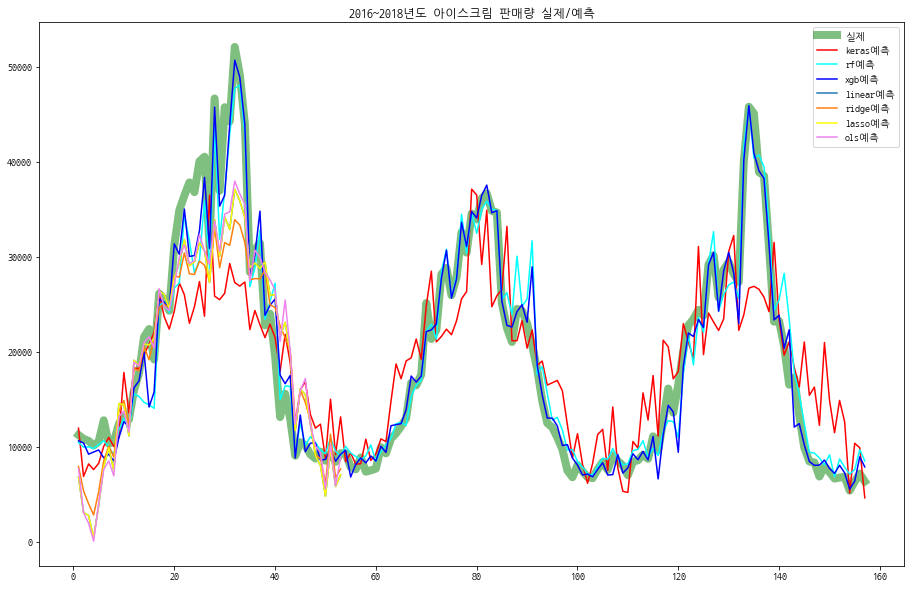

In [95]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [87]:
def r2_score(v_true, v_pred):
    ssr = np.sum(np.square(v_pred - np.mean(v_true)))
    sst = np.sum(np.square(v_true - np.mean(v_true)))
    return ( ssr / sst)

In [96]:
checked_for = '2016~2017'
combined = aaaaa.loc[:106,'temp':'PM10']
target = aaaaa.loc[:106,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)
qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

2016~2017
RF R2값  	:  0.82352
XGB R2값  	:  0.92199
KerasNN R2값	:  0.41797
LinReg R2값	:  0.79370
Ridge R2값  	:  0.64940
Lasso R2값	:  0.79369
OLS R2값	:  0.79836


In [98]:
checked_for = '2018'
combined = aaaaa.loc[106:,'temp':'PM10']
target = aaaaa.loc[106:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

2018
RF R2값  	:  0.94679
XGB R2값  	:  0.96251
KerasNN R2값	:  0.40116
LinReg R2값	:  0.88586
Ridge R2값  	:  0.74257
Lasso R2값	:  0.88584
OLS R2값	:  0.91788


In [99]:
checked_for = '2016~2018'
combined = aaaaa.loc[:,'temp':'PM10']
target = aaaaa.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

2016~2018
RF R2값  	:  0.85775
XGB R2값  	:  0.93423
KerasNN R2값	:  0.40635
LinReg R2값	:  0.81115
Ridge R2값  	:  0.66528
Lasso R2값	:  0.81113
OLS R2값	:  0.82033


In [91]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)

In [ ]:
# 날씨+sns와 아이스크림 을 사용하면 2017까진 적당하고 2018년도는 예측율 급락
#  -> 과적합화 발생
# 날씨와 아이스크림 판매량만 이용하니 ㅇㅋ